# Работа с моделью

Импорт библиотек

In [165]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Загрузка данных

In [166]:
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

Преобразование `dt` в datetime для удобного использования в Pandas

In [167]:
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)

Переименовываем колонку с ценой

In [168]:
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True)
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True)

Объединение данных и установка индекса на колонку  `dt`

In [169]:
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).sort_values('dt')
combined_df = combined_df.set_index('dt')
combined_df.to_excel('combined_df.xlsx', index=True)

Формирую признаки `(X)` и целевую переменную `(y)` для обучения модели

In [170]:
X = combined_df.drop(columns=['Price'])
y = combined_df['Price']

Разделение данных для обучения модели

In [171]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

Логарифмирование целевой переменной

In [172]:
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

Кросс-валидация

In [173]:
tscv = TimeSeriesSplit(n_splits=3)

Подбор гиперпараметров

In [174]:
params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'loss_function': 'MAE',
    'verbose': False
}

In [175]:
model = CatBoostRegressor(**params)
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

CatBoostError: Input data must have at least one feature

Лучшие параметры для модели

In [ ]:
preds_log = model.predict(X_test)
preds = np.expm1(preds_log)

In [ ]:
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")

R²: 0.6464
MAE: 5001.4672
RMSE: 6776.3530


In [ ]:
def make_forecast(model, last_date, last_prices, weeks_ahead=8):
    forecasts = []
    for week in range(1, weeks_ahead + 1):
        prediction_date = last_date + timedelta(weeks=week)
        
        # Создаем признаки для прогноза
        features = {
            'day_of_week': prediction_date.dayofweek,
            'month': prediction_date.month,
            'week_of_year': prediction_date.isocalendar().week,
            'lag_1': last_prices[-1],
            'lag_2': last_prices[-2] if len(last_prices) > 1 else last_prices[-1],
            'lag_3': last_prices[-3] if len(last_prices) > 2 else last_prices[-1],
            'lag_7': last_prices[-7] if len(last_prices) > 6 else last_prices[-1],
            'rolling_mean_7': np.mean(last_prices[-7:]),
            'rolling_mean_14': np.mean(last_prices[-14:]),
            'rolling_std_7': np.std(last_prices[-7:]) if len(last_prices) > 6 else 0,
        }
        
        # Преобразуем в DataFrame
        features_df = pd.DataFrame([features])
        
        # Прогнозируем
        pred_log = model.predict(features_df)[0]
        pred = np.expm1(pred_log)
        forecasts.append({'date': prediction_date, 'Price': pred})
    
    return pd.DataFrame(forecasts)

In [ ]:
last_date = combined_df.index[-1]
last_prices = combined_df['Price'].values[-30:]  # Берем последние 30 значений

In [ ]:
forecast = make_forecast(model, last_date, last_prices, weeks_ahead=8)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 7 should be feature with name lag_14 (found rolling_mean_7).

NameError: name 'forecast' is not defined

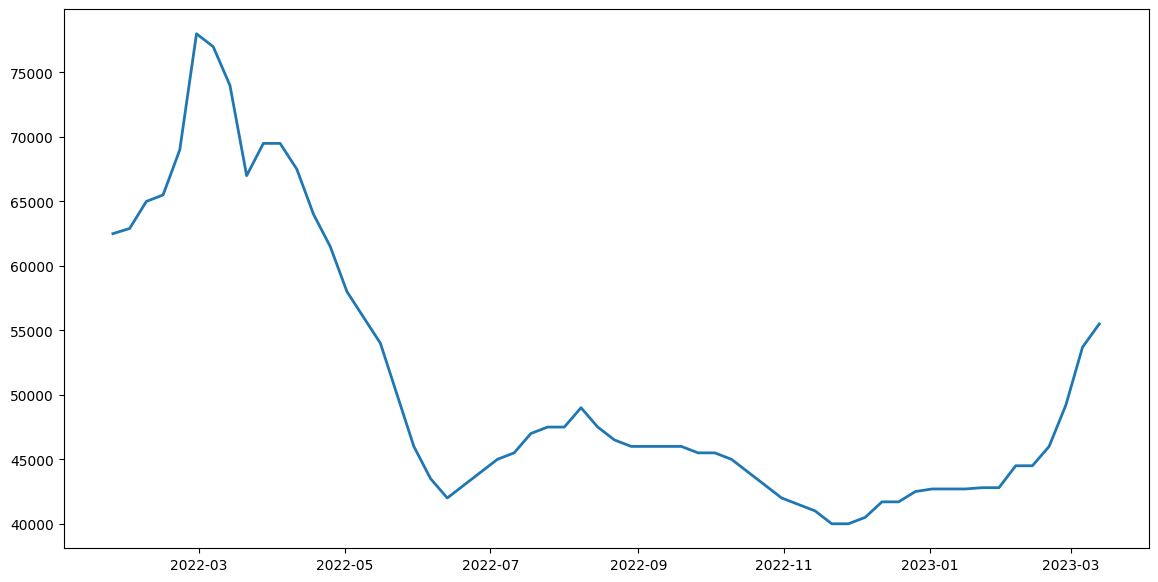

In [ ]:
plt.figure(figsize=(14, 7))
history = combined_df['Price'].iloc[-60:]  # Последние 60 дней истории
plt.plot(history.index, history, label='История цен', linewidth=2)
plt.plot(forecast['date'], forecast['price'], 'ro--', label='Прогноз')
plt.title('Прогноз цен на арматуру на 8 недель', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# best_params = grid_search.best_params_
# print("Лучшие параметры:", best_params)

Лучшие параметры: {'depth': 4, 'early_stopping_rounds': 50, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.02}


Обучение модели с лучшими параметрами

In [ ]:
# model = CatBoostRegressor(**best_params, loss_function='MAE', has_time=True, verbose=False)
# model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log), verbose=False)

Оценка модели

In [ ]:
# mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
# r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

Предсказание и оценка модели по всем метрикам

In [ ]:
# preds = np.expm1(model.predict(X_test))

# # Метрики
# print(f"R²: {r2_score(y_test, preds):.4f}")
# print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
# print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
# print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
# print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.9329
MAE: 2219.5498
MSE: 8790788.8757
RMSE: 2964.9265
Средний MAE на кросс-валидации: 0.0518
Средний R² на кросс-валидации: 0.7669


Визуализация результатов обучения модели

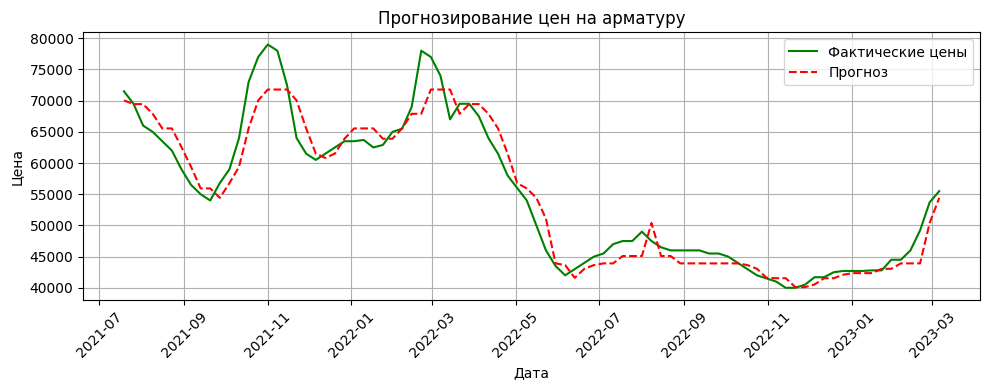

In [ ]:
# plt.figure(figsize=(10, 4))
# plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
# plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
# plt.title('Прогнозирование цен на арматуру')
# plt.xlabel('Дата')
# plt.ylabel('Цена')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Сохранение модели

In [ ]:
# model.save_model("main_model.cbm")